# Mechanism of DM-WM interplay in RNNs

Rotation-addition interaction as a mechanism of DM-WM interplay in RNNs for Figures 8a-f.

In [1]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import minimize

sys.path.append('../src/model_rnn/')
from rnn_bias import *
import rnn_bias.train as dt

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/rnn")

with open('../data/outputs/rnn/hom/trained_J.pickle', 'rb') as f:
    J_hom = pickle.load(f)

with open('../data/outputs/rnn/het/trained_J.pickle', 'rb') as f:
    J_het = pickle.load(f)

downloading data/outputs/rnn...
data/outputs/rnn already exists. Skipping download...


In [3]:
## "shorter" structure
par['strength_ref'] = 3. # stronger, to make the effect more obvious
par['batch_size']   = 1
par['kappa']        = 5
par['noise_sd']     = 0

dt.hp['w_in_dm_fix']  = True  
dt.hp['w_in_em_fix']  = True  
dt.hp['w_out_dm_fix'] = True
dt.hp['w_out_em_fix'] = True

dt.hp = dt.update_hp(dt.hp)
hp    = {k:dt.hp[k].numpy() for k in dt.hp if tf.is_tensor(dt.hp[k])}
hp['noise_rnn_sd'] = 0
hp['alpha_neuron'] = dt.hp['alpha_neuron']
hp['alpha_noise']  = dt.hp['alpha_noise']

dur = 0.6
par['design'].update({'iti'     : (0,   0.1),
                      'stim'    : (0.1, 0.7),
                      'decision': (0.8, 0.8+dur),
                      'delay'   : ((0.7, 0.8),(0.8+dur, 0.8+dur+0.1)),
                      'estim'   : (0.8+dur+0.1,0.8+dur+1.)})
par['reference'] = np.array([0,1])
par        = update_parameters(par)
stimulus   = Stimulus()
ti_spec    = dt.gen_ti_spec(stimulus.generate_trial())
trial_info = dt.tensorize_trial(stimulus.generate_trial())

In [4]:
## numpy version of forward pass
def rnn_model(input_data1, input_data2, hp, var_dict, with_noise):
    _h1 = np.zeros((par['batch_size'], 48))
    _h2 = np.zeros((par['batch_size'], 48))
    _n1 = _h1*0
    _n2 = _h2*0
    h1_stack    = []
    h2_stack    = []
    y_dm_stack  = []
    y_em_stack  = []
    for i_t in range(len(input_data1)):
        rnn_input1  = input_data1[i_t,:,:]
        rnn_input2  = input_data2[i_t,:,:]
        _n1, _n2, _h1, _h2 = rnn_cell(_n1, _n2, _h1, _h2, rnn_input1, rnn_input2, hp=hp, var_dict=var_dict, with_noise=with_noise)
        h1_stack.append(_h1.astype(np.float32))
        h2_stack.append(_h2.astype(np.float32))
        y_dm_stack.append(((_h1.astype(np.float32)+_h2.astype(np.float32)) @ hp['w_out_dm']).astype(np.float32))
        y_em_stack.append(((_h1.astype(np.float32)+_h2.astype(np.float32)) @ hp['w_out_em']).astype(np.float32))
        
    h1_stack   = np.stack(h1_stack) 
    h2_stack   = np.stack(h2_stack) 
    y_dm_stack = np.stack(y_dm_stack) 
    y_em_stack = np.stack(y_em_stack) 
    return y_dm_stack, y_em_stack, h1_stack, h2_stack

def rnn_cell(_n1, _n2, _h1, _h2, rnn_input1, rnn_input2, hp, var_dict, with_noise=False):

    _n1 = _n1.astype(np.float32)*np.exp(-hp['alpha_noise']) \
        + np.sqrt(1.-np.exp(-2.*hp['alpha_noise']))*np.random.normal(size=_n1.shape,loc=0,scale=hp['noise_rnn_sd'])
    _n2 = _n2.astype(np.float32)*np.exp(-hp['alpha_noise']) \
        + np.sqrt(1.-np.exp(-2.*hp['alpha_noise']))*np.random.normal(size=_n2.shape,loc=0,scale=hp['noise_rnn_sd'])

    _h1 = _h1.astype(np.float32) * (1. - hp['alpha_neuron']) \
        + hp['alpha_neuron'] * tf.nn.sigmoid(rnn_input1 @ hp['w_in1'] \
            + _h1.astype(np.float32) @ var_dict['J11'] \
            + _h2.astype(np.float32) @ var_dict['J21'] + with_noise*_n1 ).numpy()
    _h2 = _h2.astype(np.float32) * (1. - hp['alpha_neuron']) \
        + hp['alpha_neuron'] * tf.nn.sigmoid(rnn_input2 @ hp['w_in2'] \
            + _h1.astype(np.float32) @ var_dict['J12'] \
            + _h2.astype(np.float32) @ var_dict['J22'] + with_noise*_n2 ).numpy()
    
    return _n1, _n2, _h1, _h2

def run_rnn(par=par):
    """forward run and aggregate rnn outputs
    """
    n_ori, n_ref, n_batch, n_time = \
        par['n_ori'], len(par['reference']), par['batch_size'], par['n_timesteps']    

    r1  = np.zeros([n_time, n_ori, n_ref, n_batch, 48]) * np.nan
    r2  = np.zeros([n_time, n_ori, n_ref, n_batch, 48]) * np.nan
    
    #
    for i_stim in range(par['n_ori']):
        stim_dist = np.zeros(par['n_ori'])
        stim_dist[i_stim] = 1.
        par['stim_dist'] = stim_dist
        for i_ref, _ in enumerate(par['reference']):
            par['reference']  = par['reference']
            ref_dist          = np.zeros(len(par['reference']))
            ref_dist[i_ref]   = 1.
            par['ref_dist']   = ref_dist
            par               = update_parameters(par)
            stimulus          = Stimulus(par)
            trial_info = dt.tensorize_trial(stimulus.generate_trial())
            _, _, H1, H2  = rnn_model(trial_info['neural_input1'], trial_info['neural_input2'], hp, var_dict, with_noise=False)
            r1[:, i_stim, i_ref]    = H1
            r2[:, i_stim, i_ref]    = H2

        if i_stim % 6 == 0:
            print("Stimulus", i_stim)
            
    return r1, r2

def centered_ellipse(par, x,y):
    a,b,th = par
    t1 = (x*np.cos(th)+y*np.sin(th))**2 / a**2 
    t2 = (x*np.sin(th)-y*np.cos(th))**2 / b**2     
    loss = np.sum((1-(t1+t2))**2)
    
    return loss

def arrow(ps, pe):
    tgntslp = -ps[0]/ps[1]    
    incrvec = np.array([1,tgntslp]) / np.sqrt(1+tgntslp**2)
    incrmnt = np.dot( pe-ps, incrvec ) 
    dp      = incrmnt*incrvec
    return ps, dp

---
## Without drift

In [5]:
#
lam = 0.
var_dict = {
    'J11': (1.-lam)*J_hom['J11'].mean(axis=0) + lam*J_het['J11'].mean(axis=0),
    'J12': (1.-lam)*J_hom['J12'].mean(axis=0) + lam*J_het['J12'].mean(axis=0),
    'J21': (1.-lam)*J_hom['J21'].mean(axis=0) + lam*J_het['J21'].mean(axis=0),
    'J22': (1.-lam)*J_hom['J22'].mean(axis=0) + lam*J_het['J22'].mean(axis=0),
}
r1, r2 = run_rnn()

../src/model_rnn/rnn_bias/base/_parameters.py:91: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if par['stim_dist'] == 'uniform':
../src/model_rnn/rnn_bias/base/_parameters.py:97: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if par['ref_dist'] == 'uniform':


Stimulus 0
Stimulus 6
Stimulus 12
Stimulus 18


In [6]:
# fit PCA to the stacked r_theta (for relative reference=0)
rndseed = 2023
r_theta = (r2[:,:,0,:,:24]+r2[:,:,0,:,24:])/2.
pca_shared = PCA(n_components=2, random_state=rndseed)
pca_shared.fit(r_theta.reshape((-1,24)))

# reference directions
ref_input = np.eye(24)
ref_input_trans = np.concatenate([pca_shared.transform(ref_input[s][:24].reshape((1,-1))) for s in range(24)])

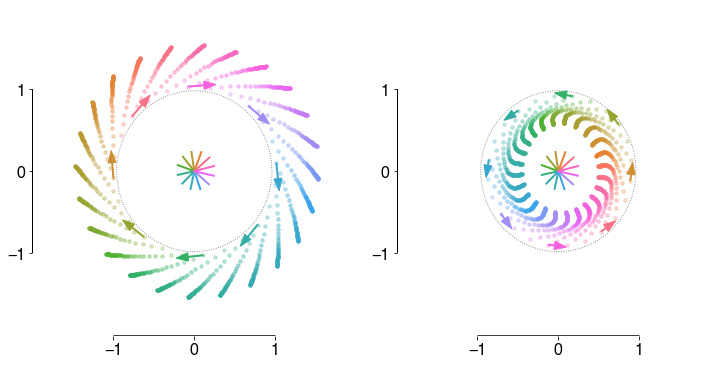

In [7]:
scale_center = 1.
scale_length = 0.2
scale_ref    = 0.8

strt = par['design_rg']['decision'][0]
dura = par['design_rg']['decision'][-1]-par['design_rg']['decision'][0]

# make ellipse
lll = np.linspace(0,np.pi*2,250,endpoint=False)
ccc = np.array([np.cos(lll), np.sin(lll)])
rrr = np.concatenate([pca_shared.transform(r1[strt:(strt+1),s,0,0,24:]) for s in range(24)])
res = minimize(centered_ellipse, [1,1,0], args=(rrr[:,0],rrr[:,1]),
               bounds=[[utils.EPS,np.inf],[utils.EPS,np.inf],[-np.pi,np.pi]])['x']
rrr = np.array([[np.cos(res[2])*res[0], -np.sin(res[2])*res[1]],
                [np.sin(res[2])*res[0],  np.cos(res[2])*res[1]]]) @ ccc

# 
fig, ax = plt.subplots(1,2)
utils.set_size([8,4])

for i in range(2): 
    ax[i].plot(rrr[0], rrr[1], color='gray', linestyle='dotted', linewidth=0.9)

for s in np.arange(24,step=2): 
    for i in range(2):
        ax[i].plot([0,ref_input_trans[s,0]*scale_ref],
                   [0,ref_input_trans[s,1]*scale_ref], 
                   color=utils.HUSL.colors[(s)%24], linewidth=2)
    
for s in np.arange(24): 
    transw = pca_shared.transform(r1[strt:(strt+dura),s,1,0,24:])
    transl = pca_shared.transform(r1[strt:(strt+dura),s,1,0,:24])
    for i_dura in range(dura):
      ax[0].scatter(transw[i_dura,0],transw[i_dura,1],
                    alpha=np.linspace(0,1,40)[10+i_dura],
                    color=utils.HUSL.colors[s], s=12)
      ax[1].scatter(transl[i_dura,0],transl[i_dura,1],
                    alpha=np.linspace(0,1,40)[10+i_dura],
                    color=utils.HUSL.colors[s], s=12)
    if s % 3 == 0:
        p, dp = arrow(transw[0,:], transw[-1,:])
        ax[0].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
        p, dp = arrow(transl[0,:], transl[-1,:])
        ax[1].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])

for i in range(2): 
    ax[i].set_xlim([-2,2])
    ax[i].set_ylim([-2,2])
    utils.draw_publish_axis(ax[i], xrange=(-1,1), yrange=(-1,1), xticks=[-1,0,1], yticks=[-1,0,1])

if utils.LABEL:
    ax[0].set_ylabel("PC2", labelpad=0)
    ax[0].set_xlabel("PC1", labelpad=0)
    ax[1].set_xlabel("PC1", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig8ab.pdf',bbox_inches='tight')
plt.show()

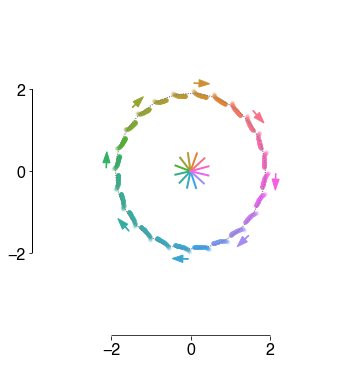

In [8]:
scale_center = 1.1
scale_length = 0.5
scale_ref    = 1.5

plt.figure()
ax = plt.gca()
utils.set_size([4,4])

# make ellipse
lll = np.linspace(0,np.pi*2,250,endpoint=False)
ccc = np.array([np.cos(lll), np.sin(lll)])
vec = (r2[strt:(strt+dura),:,0,0,:24]+r2[strt:(strt+dura),:,0,0,24:])/2.
rrr = np.concatenate([pca_shared.transform(vec[:,s,:]) for s in range(24)])
res = minimize(centered_ellipse, [1,1,0], args=(rrr[:,0],rrr[:,1]),
               bounds=[[utils.EPS,np.inf],[utils.EPS,np.inf],[-np.pi,np.pi]])['x']
rrr = np.array([[np.cos(res[2])*res[0], -np.sin(res[2])*res[1]],
                [np.sin(res[2])*res[0],  np.cos(res[2])*res[1]]]) @ ccc
for i in range(2): 
    plt.plot(rrr[0], rrr[1], color='gray', linestyle='dotted', linewidth=0.9)


#
vec = (r2[strt:(strt+dura),:,1,0,:24]+r2[strt:(strt+dura),:,1,0,24:])/2.
for s in np.arange(24): 
    trans = pca_shared.transform(vec[:,s,:])
    for i_dura in range(dura):
        plt.scatter(trans[i_dura,0], trans[i_dura,1],
                    alpha=np.linspace(0,1,30)[i_dura],
                    color=utils.HUSL.colors[s], s=12)
    if s % 3 == 0:
        p, dp = arrow(np.mean(trans[:8,:],axis=0), np.mean(trans[-8:,:],axis=0))
        plt.arrow(*(p*scale_center), *(dp*scale_length), 
                  width=0.015, head_width=0.18, zorder=3, color=utils.HUSL.colors[s])

for s in np.arange(24,step=2): 
    plt.plot([0,ref_input_trans[s,0]*scale_ref],[0,ref_input_trans[s,1]*scale_ref], 
               color=utils.HUSL.colors[(s)%24], linewidth=2)
        
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-2,2), xticks=[-2,0,2], yticks=[-2,0,2])

if utils.LABEL:
    ax.set_ylabel("PC2", labelpad=0)
    ax.set_xlabel("PC1", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig8c.pdf',bbox_inches='tight')
plt.show()

---
## With drift

In [9]:
#
lam = 1.
var_dict = {
    'J11': (1.-lam)*J_hom['J11'].mean(axis=0) + lam*J_het['J11'].mean(axis=0),
    'J12': (1.-lam)*J_hom['J12'].mean(axis=0) + lam*J_het['J12'].mean(axis=0),
    'J21': (1.-lam)*J_hom['J21'].mean(axis=0) + lam*J_het['J21'].mean(axis=0),
    'J22': (1.-lam)*J_hom['J22'].mean(axis=0) + lam*J_het['J22'].mean(axis=0),
}
r1, r2 = run_rnn()

../src/model_rnn/rnn_bias/base/_parameters.py:91: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if par['stim_dist'] == 'uniform':
../src/model_rnn/rnn_bias/base/_parameters.py:97: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if par['ref_dist'] == 'uniform':


Stimulus 0
Stimulus 6
Stimulus 12
Stimulus 18


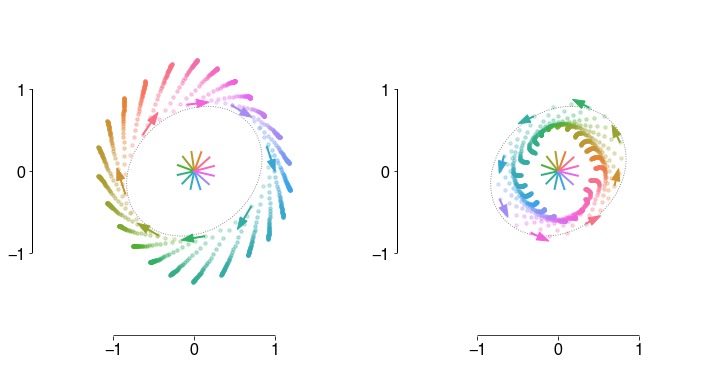

In [10]:
scale_center = 1.
scale_length = 0.2
scale_ref    = 0.8

# make a circle
lll = np.linspace(0,np.pi*2,250,endpoint=False)
ccc = np.array([np.cos(lll), np.sin(lll)])
rrr = np.concatenate([pca_shared.transform(r1[strt:(strt+1),s,0,0,24:]) for s in range(24)])
res = minimize(centered_ellipse, [1,1,0], args=(rrr[:,0],rrr[:,1]),
               bounds=[[utils.EPS,np.inf],[utils.EPS,np.inf],[-np.pi,np.pi]])['x']
rrr = np.array([[np.cos(res[2])*res[0], -np.sin(res[2])*res[1]],
                [np.sin(res[2])*res[0],  np.cos(res[2])*res[1]]]) @ ccc

#
fig, ax = plt.subplots(1,2)
utils.set_size([8,4])

for i in range(2): 
    ax[i].plot(rrr[0], rrr[1], color='gray', linestyle='dotted', linewidth=0.9)

for s in np.arange(24,step=2): 
    for i in range(2):
        ax[i].plot([0,ref_input_trans[s,0]*scale_ref],[0,ref_input_trans[s,1]*scale_ref], 
                   color=utils.HUSL.colors[(s)%24], linewidth=2)
    
for s in np.arange(24): 
    transw = pca_shared.transform(r1[strt:(strt+dura),s,1,0,24:])
    transl = pca_shared.transform(r1[strt:(strt+dura),s,1,0,:24])
    for i_dura in range(dura):
      ax[0].scatter(transw[i_dura,0],transw[i_dura,1],
                    alpha=np.linspace(0,1,40)[10+i_dura],
                    color=utils.HUSL.colors[s], s=12)
      ax[1].scatter(transl[i_dura,0],transl[i_dura,1],
                    alpha=np.linspace(0,1,40)[10+i_dura],
                    color=utils.HUSL.colors[s], s=12)
    if s % 3 == 0:
        p, dp = arrow(transw[0,:], transw[-1,:])
        ax[0].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
        p, dp = arrow(transl[0,:], transl[-1,:])
        ax[1].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])

for i in range(2): 
    ax[i].set_xlim([-2,2])
    ax[i].set_ylim([-2,2])
    utils.draw_publish_axis(ax[i], xrange=(-1,1), yrange=(-1,1), xticks=[-1,0,1], yticks=[-1,0,1])

if utils.LABEL:
    ax[0].set_ylabel("PC2", labelpad=0)
    ax[0].set_xlabel("PC1", labelpad=0)
    ax[1].set_xlabel("PC1", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig8de.pdf',bbox_inches='tight')
plt.show()

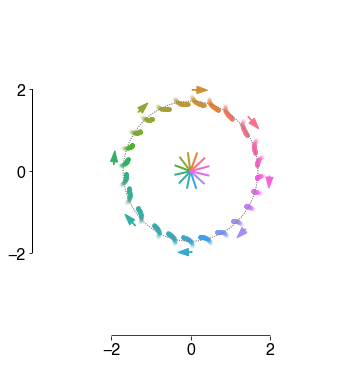

In [11]:
scale_center = 1.1
scale_length = 0.5
scale_ref    = 1.5

plt.figure()
ax = plt.gca()
utils.set_size([4,4])

# make ellipse
lll = np.linspace(0,np.pi*2,250,endpoint=False)
ccc = np.array([np.cos(lll), np.sin(lll)])
vec = (r2[strt:(strt+dura),:,0,0,:24]+r2[strt:(strt+dura),:,0,0,24:])/2.
rrr = np.concatenate([pca_shared.transform(vec[:,s,:]) for s in range(24)])
res = minimize(centered_ellipse, [1,1,0], args=(rrr[:,0],rrr[:,1]),
               bounds=[[utils.EPS,np.inf],[utils.EPS,np.inf],[-np.pi,np.pi]])['x']
rrr = np.array([[np.cos(res[2])*res[0], -np.sin(res[2])*res[1]],
                [np.sin(res[2])*res[0],  np.cos(res[2])*res[1]]]) @ ccc
for i in range(2): 
    plt.plot(rrr[0], rrr[1], color='gray', linestyle='dotted', linewidth=0.9)

#
vec = (r2[strt:(strt+dura),:,1,0,:24]+r2[strt:(strt+dura),:,1,0,24:])/2.
for s in np.arange(24): 
    trans = pca_shared.transform(vec[:,s,:])
    for i_dura in range(dura):
        plt.scatter(trans[i_dura,0], trans[i_dura,1],
                    alpha=np.linspace(0,1,30)[i_dura],
                    color=utils.HUSL.colors[s], s=12)
    if s % 3 == 0:
        p, dp = arrow(np.mean(trans[:8,:],axis=0), np.mean(trans[-8:,:],axis=0))
        plt.arrow(*(p*scale_center), *(dp*scale_length), 
                  width=0.015, head_width=0.18, zorder=3, color=utils.HUSL.colors[s])

for s in np.arange(24,step=2): 
    plt.plot([0,ref_input_trans[s,0]*scale_ref],[0,ref_input_trans[s,1]*scale_ref], 
               color=utils.HUSL.colors[(s)%24], linewidth=2)

#
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-2,2), xticks=[-2,0,2], yticks=[-2,0,2])

if utils.LABEL:
    ax.set_ylabel("PC2", labelpad=0)
    ax.set_xlabel("PC1", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig8f.pdf',bbox_inches='tight')
plt.show()